# Generate Masks for Time Series Data

## Setup

In [1]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
    !pip3 install git+https://github.com/pvigier/perlin-numpy astropy geopy
%pwd

import h5py
import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (16,8)

from tensorflow.keras.models import load_model
from osgeo                   import gdal
from PIL                     import Image
from src.io                  import get_image_array
from src.inference           import mask_with_model, mask_simulated
from src.sarsim              import gen_simulated_deformation, gen_sim_noise, gen_simulated_time_series

/home/jovyan/AI-Event-Monitoring
  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-8isddccj
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-8isddccj
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done


## Load Data

In [2]:
timeseries_filename = f"notebooks/{input('path to timeseries h5 file: ')}"
unwrapped = h5py.File(timeseries_filename, 'r').get('/timeseries')[...]

print(unwrapped[1].shape)

path to timeseries h5 file:  Images/sample products/unimak44/timeseries_ERA5_demErr.h5


(607, 965)


## Show Data

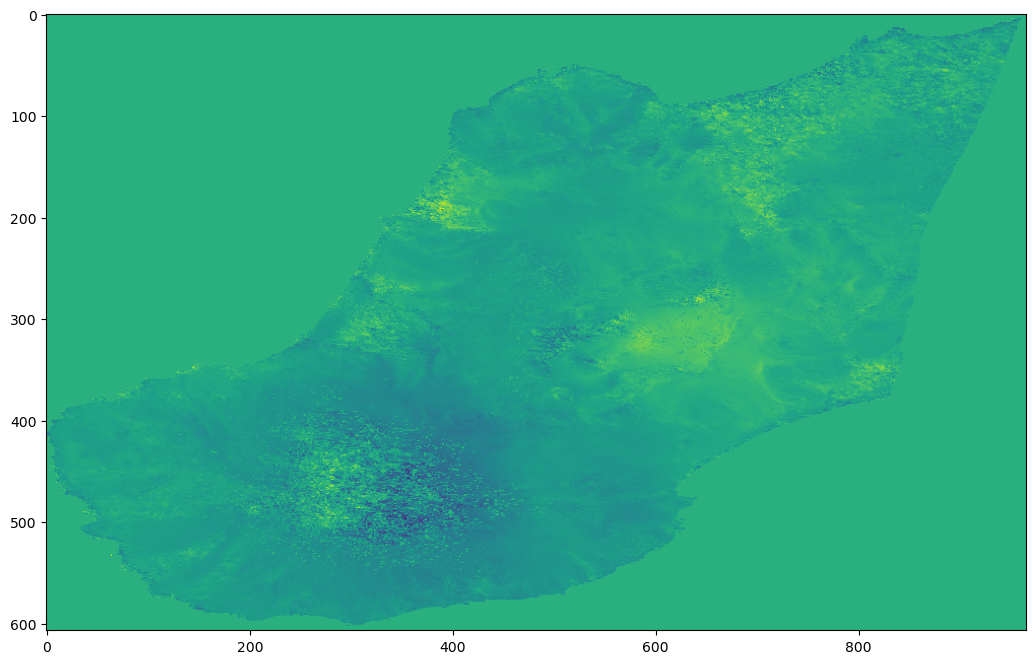

In [3]:
plt.imshow(unwrapped[1])

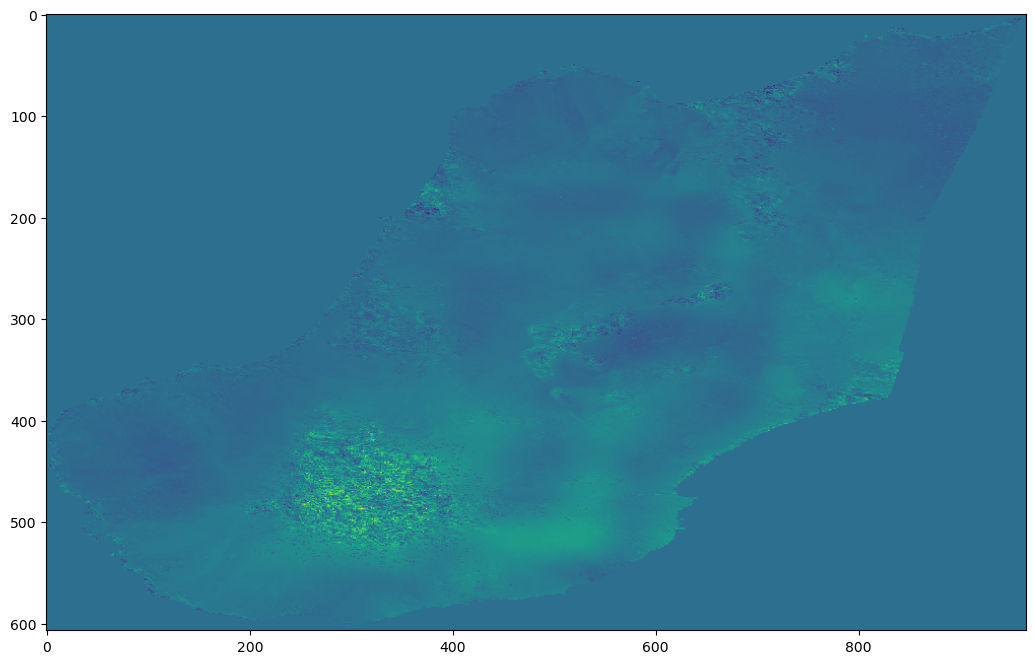

In [4]:
plt.imshow(unwrapped[100])

## Process Data

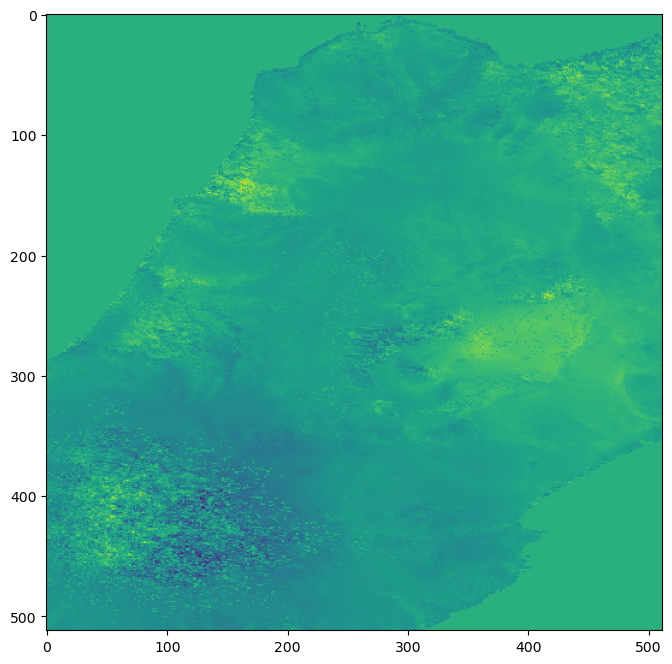

In [5]:
tile_size = 512
crop_size = 512

wrapped = np.angle(np.exp(1j * (unwrapped)))

#Currently crops data to fit into model instead of tiling
z, x, y = wrapped.shape
wrapped = wrapped[:16, x//2 - 256:x//2 + 256, y//2 - 256:y//2 + 256]

plt.imshow(wrapped[1])

## Run Prediction

In [6]:
tile_size = 512
crop_size = 512

mask_model_path = 'notebooks/models/time_series_masking_model'

mask_model = load_model(mask_model_path)

wrapped   = wrapped.transpose(1, 2, 0)
wrapped   = wrapped.reshape((1, *wrapped.shape, 1))
mask_pred = np.float32(mask_model.predict(wrapped))

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Process Mask

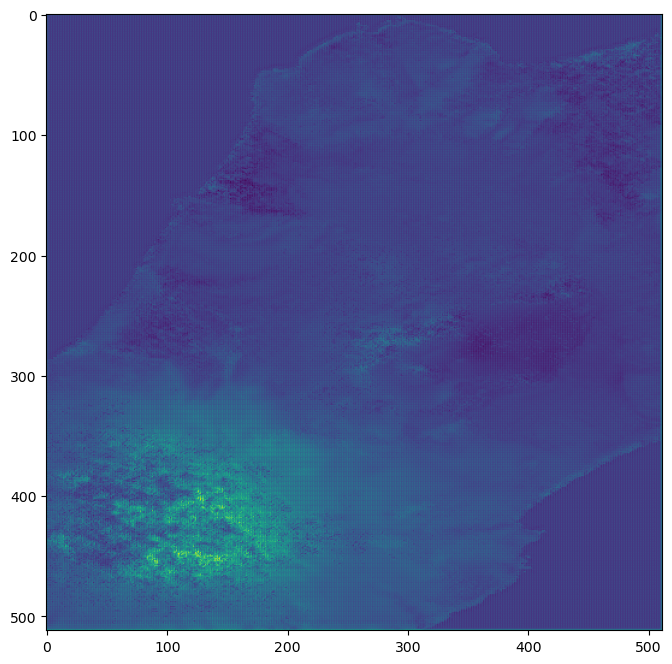

In [7]:
mask_accumulated = np.zeros((512, 512))
for i in range(16):
    mask_accumulated += mask_pred[0, :, :, i, 0]
plt.imshow(np.angle(np.exp(1j * mask_accumulated)))

mask = mask_accumulated
mask[mask == 0] = 0
mask[mask >= 0.5] = 1
mask[mask < 0.5] = 0

## Plot Mask

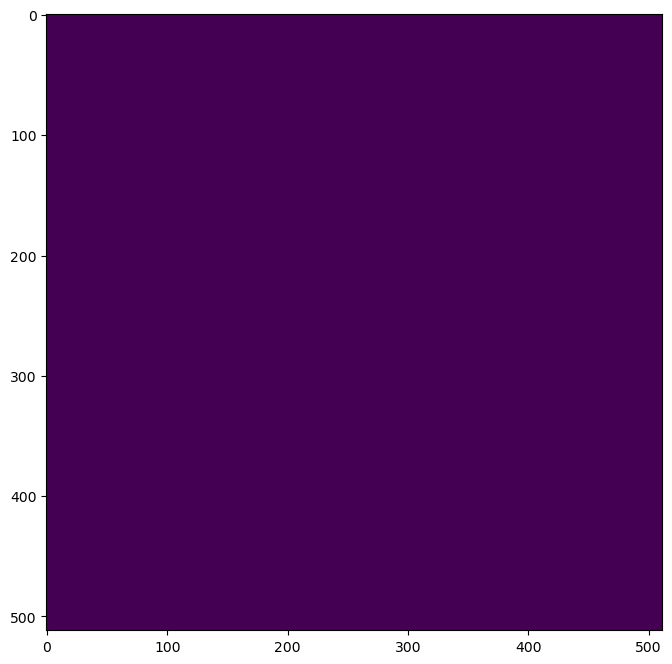

In [8]:
plt.imshow(np.angle(np.exp(1j * mask)))